In [1]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\mzig2\anaconda3\lib\site-packages (0.23.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Data Management

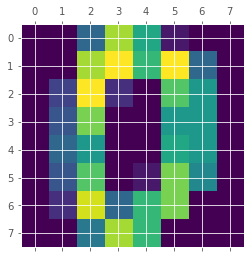

In [5]:
from sklearn.datasets import load_digits
 
digits = load_digits()
import matplotlib.pyplot as plt 
plt.matshow(digits.images[0]) 
plt.show()

In [6]:
#flattening to 1D arrays
#partitioning to training set, testing set, validation set
from sklearn.model_selection import train_test_split
X_train, X_other, y_train, y_other = train_test_split(digits.data, digits.images, test_size=0.2, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.5, shuffle=False)
print("Numbers to train: " + str(len(X_train)))
print("Numbers to test: " + str(len(X_test)))
print("Numbers to validate: " + str(len(X_val)))

Numbers to train: 1437
Numbers to test: 180
Numbers to validate: 180


### Test set starts after training set in partition
### Validation set starts after test set

6


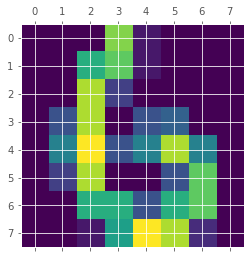

In [7]:
i=36
plt.matshow(X_test[i].reshape(8,8))
print(digits.target[len(X_train)+i])

## Poisson Encoding

### 2.2.d)

For this modified SNN, we decided to employ a Poisson Encoding scheme in order to generate a spike train representation for each of our images. Citing this paper https://arxiv.org/ftp/arxiv/papers/1604/1604.06751.pdf, our algorithm for doing so was as follows:

- normalize all r rate (pixel intensity) values to be between 0 and 1
- generate M uniform random numbers between 0 and 1 where M is equal to the number of bins of time we're examining spiking   activity (since dT = 1, M will be equal to the size of the array)
- for all i in M random numbers in rand, if r[i] > rand[i], generate 1 spike

After executing this process, 3 arrays will be returned of size M: one containing the normalized pixel intensities of each bin, one containing their binary spike values, and one consisting of the maximum amount of intensity at each index where a spike occurs for plotting purposes.

In [8]:
def poissonEncoding(rates):
    """
    Transforms a 1D array of inputs representing an image into spike train representation utilizing Poisson method of
    encoding
    
    Params:
        rates: 1D array of inputs (in this case, pixel intensitiies corresponding to our image)
    Returns:
        n_rates: Normalized set of input pixel values (represents probabilities of a spike occurring at each dT)
        bin_spikes: 1D array of binary values representing timesteps in which spikes occur
        p_spikes: 1D array representing pixel intensities of spike train representation for plotting/computation purposes
        
    """
    dT = 1
    
    max = np.amax(rates)
    n_rates = (rates*dT)/max
    
    rand = np.random.uniform(0,1, len(rates))
    bin_spikes = np.zeros(len(rates))
    pix_spikes = np.zeros(len(rates))
    
    for i in range(len(rates)):
        if n_rates[i] > rand[i]:
            bin_spikes[i] = 1
            pix_spikes[i] = max
                    
    return n_rates, bin_spikes, pix_spikes
    

0


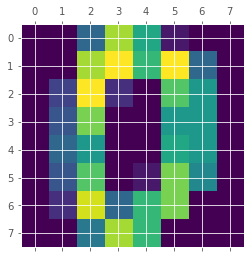

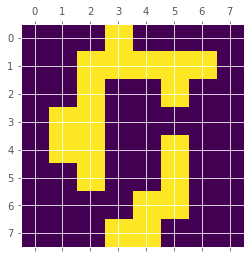

1797

In [9]:
plt.matshow(np.reshape(X_train[0], (8,8))) 
print(digits.target[0])
n, b, p = poissonEncoding(X_train[0])
plt.matshow(p.reshape(8,8))
plt.show()

len(digits.images)

 ## Network Functions

In [10]:
def train(X, Y, val, l_rt, init, epochs):
    
    weights = init
    
    for i in range(epochs):
        
        print("epoch: ", i)
        print("training......")
        for x in range(len(X)):
            
            true_index = digits.target[x]
            #print("index: ", x, " true index: ", true_index)
            in_neurons = X[x]
            out_neurons = Y[x]
            
            X_n_rts, X_bins, X_pixs = poissonEncoding(in_neurons)
                        
            weight_adjs = np.zeros((len(in_neurons),10))
            
            y_out  = np.zeros((10,len(in_neurons)))
            y_out[true_index] = out_neurons.flatten()
                        
            for pix in range(len(in_neurons)):
                for digit in range(10):
                   weight_adjs[pix][digit] = l_rt*X_bins[pix]*y_out[digit][pix]
                
            weights = weights + weight_adjs
            
            if (i == 0) and (x % 250 == 0):
                print("********************")
                print("validating after ",x,"th image:")
                validate(X,val,weights.T,0,len(X_train)+len(X_test))
                
        print("weights after epoch ", i,": ", weights, "\n")
        validate(X, val, weights.T, 0, len(X_train)+len(X_test))
        print("------------------------------")
        
        
    return weights.T


def validate(train, val, weights, ind_train, ind_val):
    
    train_correct = 0
    val_correct = 0
    
    for i in range(len(train)):
        prediction = _predict(train[i], weights)
        if prediction == digits.target[ind_train+i]:
            train_correct+=1
    train_accuracy = train_correct/len(train)
    print("training accuracy: ", train_accuracy)
    
    for j in range(len(val)):
        prediction = _predict(val[j], weights)
        if prediction == digits.target[ind_val+j]:
            val_correct+=1
    val_accuracy = val_correct/len(val)
    print("validation accuracy: ", val_accuracy)
    
    print("total accuracy: ", (train_correct+val_correct)/(len(train)+len(val)))
    
        

def predict(test, weights, targ):
    
    print("image value: ", targ)
    
    n, spikes, p = poissonEncoding(test)
    outs = np.zeros(len(weights))
    for i in range(len(weights)):
        outs[i] = np.dot(spikes, weights[i])
    
    prediction = np.argmax(outs)
    
    print("predicted value: ", prediction)
    
    if (prediction == targ):
        return True
    else:
        return False
    
def _predict(test, weights):
    
    n, spikes, p = poissonEncoding(test)
    outs = np.zeros(len(weights))
    
    for i in range(len(weights)):
        outs[i] = np.dot(spikes, weights[i])
    
    return np.argmax(outs)
    
def sim(test, weights, ind_targ):
    
    correct = 0
    
    for i in range(len(test)):
        
        x = predict(test[i], weights, digits.target[ind_targ+i])
        
        print("prediction correct: ", x)
        print("------------------------------")
        
        if x:
            correct += 1
            
    return correct/len(test) 


## Training

In [ ]:
init_weights = np.zeros((len(X_train[0]),10))

#w_i,j = w_out,pix
weights = train(X_train, y_train, X_val, 0.0008, init_weights, 3)

epoch:  0
training......
********************
validating after  0 th image:
training accuracy:  0.09951287404314545
validation accuracy:  0.08888888888888889
total accuracy:  0.09833024118738404
********************
validating after  250 th image:
training accuracy:  0.6172581767571329
validation accuracy:  0.5666666666666667
total accuracy:  0.6116264687693259
********************
validating after  500 th image:
training accuracy:  0.6102992345163535
validation accuracy:  0.5
total accuracy:  0.5980210265924552
********************
validating after  750 th image:
training accuracy:  0.6207376478775226
validation accuracy:  0.5611111111111111
total accuracy:  0.614100185528757


## Validation Testing

In [ ]:
validate(X_train, X_val, weights, 0, len(X_train)+len(X_test))

## Final Testing

In [ ]:
accuracy = sim(X_test, weights, len(X_train))
print("accuracy: ", accuracy)